# <span style="color:yellow">New Classes and Some Functions</span>

In [6]:
from TMclass import *
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xml.etree import ElementTree
from datetime import datetime as DT
from datetime import timedelta as TD

TM3 = {'date':[], 'tm_rate':[], 'duration':[]}
TM3n = {'date':[], 'tm_rate':[], 'duration':[]}
TM13 = {'date':[], 'tm_rate':[], 'duration':[]}

# you have to remove what is inside <eventfile>
with open('../SIFECS_NMP_Segment_2_withLTP10-11FECS.xml') as f:
	tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2023,1,1) and d <= datetime.date(2024,1,1):
        TM3['date'] += [DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TM3['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM3['duration'] += [int(node.attrib.get('duration'))]

TM3['date'] = np.asarray(TM3['date'])
TM3['tm_rate'] = np.asarray(TM3['tm_rate'])
TM3['duration'] = np.asarray(TM3['duration'])

with open('../FECS_2023072_2023177_2022348130413_v03.SOL') as f:
	tree = ElementTree.parse(f)
for node in tree.iter('PASS'):
    d = DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2023,1,1) and d <= datetime.date(2024,1,1):
        TM3n['date'] += [DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TM3n['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM3n['duration'] += [int(node.attrib.get('duration'))]

TM3n['date'] = np.asarray(TM3n['date'])
TM3n['tm_rate'] = np.asarray(TM3n['tm_rate'])
TM3n['duration'] = np.asarray(TM3n['duration'])

with open('../SIFECS_SIFECS_LTP12-13_preFECS_Mission_Level_Plan_for_LTP12_and_13_2.xml') as f:
	tree = ElementTree.parse(f)
for node in tree.iter('PASS'):
    d = DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2023,1,1) and d <= datetime.date(2024,1,1):
        TM13['date'] += [DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TM13['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM13['duration'] += [int(node.attrib.get('duration'))]

TM13['date'] = np.asarray(TM13['date'])
TM13['tm_rate'] = np.asarray(TM13['tm_rate'])
TM13['duration'] = np.asarray(TM13['duration'])

idx0 = np.where(TM3['date'] > TM3n['date'][0])[0][0]
idx1 = np.where(TM3['date'] < TM3n['date'][-1])[0][-1]
TM3['date'] = np.concatenate((TM3['date'][:idx0],TM3n['date'],TM3['date'][idx1:]))
TM3['tm_rate'] = np.concatenate((TM3['tm_rate'][:idx0],TM3n['tm_rate'],TM3['tm_rate'][idx1:]))
TM3['duration'] = np.concatenate((TM3['duration'][:idx0],TM3n['duration'],TM3['duration'][idx1:]))

idx0 = np.where(TM3['date'] > TM13['date'][0])[0][0]
idx1 = np.where(TM3['date'] < TM13['date'][-1])[0][-1]
TM3['date'] = np.concatenate((TM3['date'][:idx0],TM13['date'],TM3['date'][idx1:]))
TM3['tm_rate'] = np.concatenate((TM3['tm_rate'][:idx0],TM13['tm_rate'],TM3['tm_rate'][idx1:]))
TM3['duration'] = np.concatenate((TM3['duration'][:idx0],TM13['duration'],TM3['duration'][idx1:]))

f = open('../phi.itl','r')
lines = f.readlines()

FL = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FL['date'] += [DT.fromisoformat(temp[0][:-1])]
        FL['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FL['date'] = np.asarray(FL['date'])
FL['flush'] = np.asarray(FL['flush'])

# for i in range(np.size(TM3['date'])):
#     j = 0
#     if TM3['date'][i] >= TM3n['date'][0] and TM3['date'][i] <= TM3n['date'][-1]:
#         TM3['date'][i] = TM3n['date'][j]
#         TM3['tm_rate'][i] = TM3n['tm_rate'][j]
#         TM3['duration'][i] = TM3n['duration'][j]
#         j += 1

In [7]:
def flush_many(PHI,max_vol, vol_dataset, phi_mode, start, nbits, ndata, level, partition):
    # global PHI
    # global phi
    
    def _new_start(start,end):
        start += TD(days=1)
        start = start.replace(hour=22,minute=0,second=0)
        if end > start:
            start = end + TD(hours=1)
        return start
    
    vol0 = max_vol[0]
    vol1 = max_vol[1]
    n0 = int(vol0 // vol_dataset * 0.99)
    n1 = int(vol1 // vol_dataset * 0.99)

    if ndata == -1:
        ndata = phi_mode.level_out(level).n_datasets
    
    print(f'Days needed: {(ndata-n0)//n1+2}')
    kw = phi_mode.compressing(start, nbits = nbits, ndata = n0,level=level); PHI.saving(partition,**kw)
    # start += TD(days=1)
    start = _new_start(start,kw['end'])

    for i in range((ndata-n0)//n1+1):
        kw = phi_mode.compressing(start, nbits = nbits, ndata = min(ndata - n0 - i*n1,n1),level=level); PHI.saving(partition,**kw)
        start = _new_start(start,kw['end'])

    return (phi_mode, kw)
    
def synoptic(PHI,mode,t0,t1,cadence,shape,nout,nbits,i,format = False):
    # t0 = DT.fromisoformat('2023-04-15T00:00:00')
    # t1 = DT.fromisoformat('2023-05-01T00:00:00')

    # cad = 6*60
    # global PHI
    N = int((t1 - t0).total_seconds() / (60*cadence))

    ti = t0
#     deltat = (t1 - t0)/N
    deltat = TD(minutes=cadence)
    
    min2 = TD(minutes=2)
    form = False
    for n in range(N):
        kw = mode.observation(ti,ti+min2,cadence=2,shape=shape); PHI.saving(i,**kw)
        if shape[1] != 2048:
            kw = mode.cropping(kw['end'] + TD(minutes=5),ndata=-1,crop=[shape[1],shape[1]],level='raw'); PHI.saving(i,**kw)
            kw = mode.processing(kw['end'] + TD(minutes=5),ndata=-1,partialStore=0x00,level='raw.crop',nout=nout); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.crop.proc'); PHI.saving(i,**kw)
        else:
            kw = mode.processing(kw['end'] + TD(minutes=5),ndata=-1,partialStore=0x00,level='raw',nout=nout); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.proc'); PHI.saving(i,**kw)
        ti = ti + deltat
        if format:
            if PHI.part1.occu > 220e3 or PHI.part2.occu > 220e3:
                PHI.format_partition(i,kw['end'])
                i = i%2 + 1

def synoptic_raw(PHI,mode,t0,t1,cadence,shape,nbits,i, crop_pack = True, format = False):
    # t0 = DT.fromisoformat('2023-04-15T00:00:00')
    # t1 = DT.fromisoformat('2023-05-01T00:00:00')

    # cad = 6*60
    # global PHI
    N = int((t1 - t0).total_seconds() / (60*cadence))

    ti = t0
#     deltat = (t1 - t0)/N
    deltat = TD(minutes=cadence)
    
    min2 = TD(minutes=2)
    form = False
    for n in range(N):
        kw = mode.observation(ti,ti+min2,cadence=2,shape=shape); PHI.saving(i,**kw)
        if shape[1] != 2048:
            kw = mode.cropping(kw['end'] + TD(minutes=5),ndata=-1,crop=[shape[1],shape[1]],level='raw');
            if crop_pack == False:
                PHI.saving(i,**kw)
            kw = mode.packing(kw['end'] + TD(minutes=5),ndata=-1,level='raw.crop'); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.crop.pack'); PHI.saving(i,**kw)
        else:
            kw = mode.packing(kw['end'] + TD(minutes=5),ndata=-1,level='raw'); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.pack'); PHI.saving(i,**kw)
        ti = ti + deltat
        if format:
            if PHI.part1.occu > 220e3 or PHI.part2.occu > 220e3:
                PHI.format_partition(i,kw['end'])
                i = i%2 + 1

def FDT_flat(PHI,t0,idx,proc='auto',flush='auto',verbose=True):

    # global PHI
    t1 = t0+TD(minutes=55)
    proc_time = TD(hours=5)

    FDTf1 = PHI_MODE('FDT')

    kw = FDTf1.observation(t0,t1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = FDTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = FDTf1.packing(t0,ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = FDTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(FDTf1, label='FDT Flat Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return FDTf1

def HRT_flat(PHI,t0,idx,proc='auto',flush='auto',verbose=True):
    # global PHI
    proc_time = TD(minutes=15)

    HRTf1 = PHI_MODE('FDT')

    kw = HRTf1.observation(t0,10,cadence=40,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = HRTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = HRTf1.packing(kw['end'],ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = HRTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(HRTf1, label='HRT Flat Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return HRTf1

def HRT_kll(PHI,t0,idx,proc='auto',flush='auto',verbose=True):
    # global PHI
    t1 = t0+TD(minutes=55)
    proc_time = TD(hours=5)

    HRTf1 = PHI_MODE('FDT')

    kw = HRTf1.observation(t0,t1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = HRTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = HRTf1.packing(t0,ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = HRTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(HRTf1, label='HRT Kll Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return HRTf1

def plot_flush_per_day(PHI,xlim=None, values=False):
    temp = PHI.part1.history    # plt.subplot(121)
    c1 = np.asarray(PHI.part1.history['compr'])
    c2 = np.asarray(PHI.part2.history['compr'])

    d1 = np.asarray(PHI.part1.history['start'])
    d2 = np.asarray(PHI.part2.history['start'])

    starttime = min(d1[0],d2[0])
    endtime = max(max(d1),max(d2))
    t0 = starttime
    times = []
    while starttime.date() <= endtime.date():
        times.append(starttime.date())
        starttime += datetime.timedelta(days=1)
    starttime = t0; del t0
    times_float = [(t - d1[0]).total_seconds() for t in d1]
    times = np.asarray(times)

    newc1 = np.zeros(np.size(times))
    for i,j in zip(d1,c1):
        if j>=0:
            ind = np.where(times == i.date())[0]
            newc1[ind] += j/1e3
    newc1 = np.asarray(newc1)

    newc2 = np.zeros(np.size(times))
    for i,j in zip(d2,c2):
        if j>=0:
            ind = np.where(times == i.date())[0]
            newc2[ind] += j/1e3
    newc2 = np.asarray(newc2)

    total = 0
    for i,t in enumerate(times):
        if t >= xlim[0].date() and t<= xlim[1].date():
            total += newc1[i] + newc2[i]

    plt.figure(figsize=(15,12))
    # plt.plot_date(times,newc1,color='blue',linestyle='-',marker='.',label='partition 1')
    # plt.plot_date(times,newc2,color='red',linestyle='-',marker='.',label='partition 2')
    plt.plot_date(times,newc1+newc2,color='black',linestyle='-',marker='.',label='total: '+str(round(total,1))+' GB')
    plt.gcf().autofmt_xdate()
    plt.grid()
    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    plt.ylabel('flush (GB/day)')

    if values:
        return times, newc1, newc2


(0.0, 4500.0)

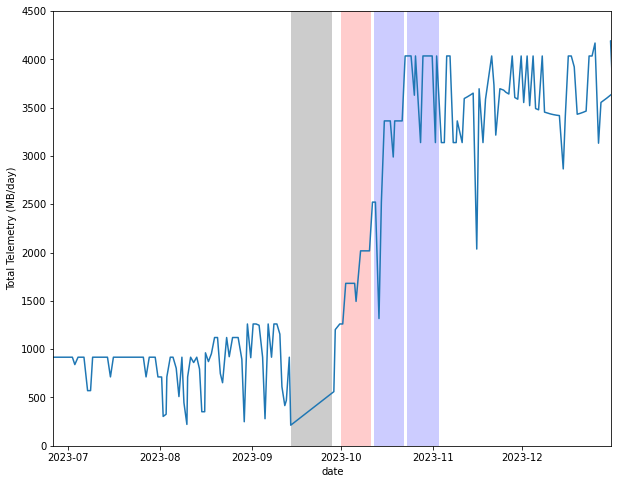

In [8]:
plt.figure(figsize=(10,8))
plt.plot(TM3['date'], (TM3['tm_rate']*TM3['duration'])/8/1e6)#; plt.ylim(0,5000)
plt.ylim(0,4500)
ylim = plt.gca().get_ylim()
plt.fill_betweenx(ylim,DT(2023,9,14),DT(2023,9,28),facecolor='black',alpha=.2)
plt.fill_betweenx(ylim,DT(2023,10,1),DT(2023,10,11),facecolor='red',alpha=.2)
plt.fill_betweenx(ylim,DT(2023,10,12),DT(2023,10,22),facecolor='blue',alpha=.2)
plt.fill_betweenx(ylim,DT(2023,10,23),DT(2023,11,3),facecolor='blue',alpha=.2)
plt.xlim(datetime.date(2023,6,26),datetime.date(2023,12,31))
plt.ylabel('Total Telemetry (MB/day)')
plt.xlabel('date')
plt.ylim(ylim)

# <span style="color:white">*out of RSWs*</span>

## <span style="color:blue">Synoptics</span>

CROP 1536


In [22]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-04-26T00:00:00')
# t1 = DT.fromisoformat('2023-09-30T00:00:00')
PHI = PHI_MEMORY(t0)

Syn = [PHI_MODE('FDT') for i in range(10)]
crop = [1408,1280,1024,896,768,896,1024,1280,1408,1536]
duration = [6,13,9,23,51,20,11,12,6,5]

cad = np.asarray([4,4,4,4,4,4,4,4,4,4]); 

for i,s in enumerate(Syn):
    cr = crop[i] 
    d = duration[i]
    c = 24/cad[i] * 60
    t1 = t0 + TD(days=d)
    kw = s.observation(t0,t1,c,(2048,cr,4,6)); PHI.saving(id,**kw)
    kw = s.cropping(kw['end'],cr,-1,'raw')
    kw = s.packing(kw['end'],-1,'raw.crop'); PHI.saving(id,**kw)
    # kw = s.compressing(kw['end'],6,-1,'raw.crop.pack',); PHI.saving(id,**kw)
    t0 = t1
    printp(s, label='Synoptic')

########################################################


Synoptic
number of datasets: 24
cadence: 360.0 mins
duration: 6 days, 0:00:00
amount of raw-data at 32 bits: 6591.8 MiB, 274.7 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 4577.6 MiB, 190.7 MiB per dataset
cropping time: 0:28:00
amount of pack-data at 16 bits: 2380.4 MiB, 99.2 MiB per dataset
packing time: 0:36:00
amount of metadata:  576 MiB
amount of memory usage: 13549.8 MiB

Synoptic
number of datasets: 52
cadence: 360.0 mins
duration: 13 days, 0:00:00
amount of raw-data at 32 bits: 13092.0 MiB, 251.8 MiB per dataset
crop size: 1280
amount of crop-data at 32 bits: 8331.3 MiB, 160.2 MiB per dataset
cropping time: 1:00:40
amount of pack-data at 16 bits: 4364.0 MiB, 83.9 MiB per dataset
packing time: 1:18:00
amount of metadata:  1248 MiB
amount of memory usage: 25787.4 MiB

Synoptic
number of datasets: 36
cadence: 360.0 mins
duration: 9 days, 0:00:00
amount of raw-data at 32 bits: 7415.8 MiB, 206.0 MiB per dataset
crop size: 1024
amount of crop-data at 32 bits: 3845

In [19]:
print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e-3,2), 'GB')

amount of compressed data + metadata in partition 2: 10.14 GB


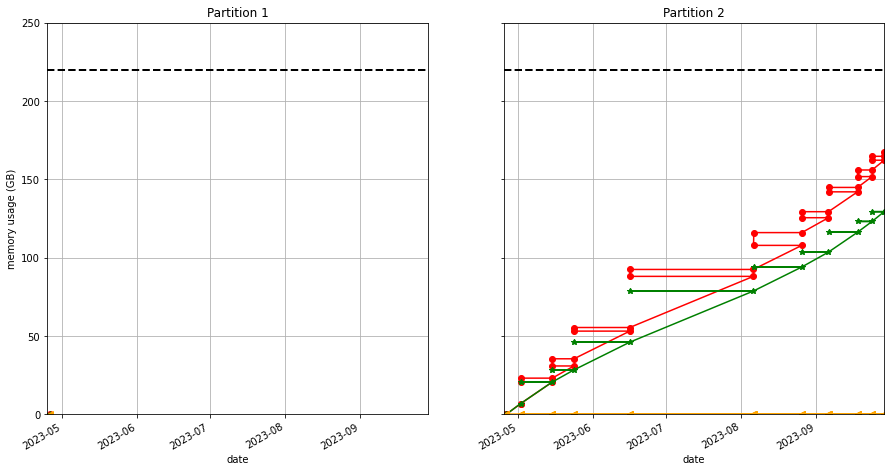

In [23]:
xlim = (DT(2023,4,25,0,0,0),DT(2023,9,29,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)

## <span style="color:magenta">***RESET NAND 2 (with Synoptics)***</span>

In [5]:
print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e-3,2), 'GB')
print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e-3,2), 'GB')
# print('TM time:',round((PHI.part1.compr + PHI.part2.compr)/2151.3,2), 'days')
# PHI.format_partition(1,DT(2023,1,29,16,0,0))
# PHI.format_partition(2,end + TD(hours=1))
# PHI.format_partition(1,end + TD(hours=1))
# PHI.format_partition(2,PHI.part1.history['end'][-1] + TD(hours=.5))
PHI.format_partition(2,DT(2023,10,9,6,0,0))


amount of compressed data + metadata in partition 1: 0.0 GB
amount of compressed data + metadata in partition 2: 4.93 GB


## <span style="color:green">FDT Flat 1 </span>

In [6]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-09-30T21:30:00')
FDTflat1 = FDT_flat(PHI,t0,id,proc = 'auto', flush = 'auto',verbose=False)
########################################################
printp(FDTflat1, label="FDT FLAT 1 (30/09/2023)")

FDT FLAT 1 (30/09/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4173.3 MiB



# <span style="color:orange">*RSW 10*</span>

## <span style="color:blue">Coronal Dynamics 1</span>

In [30]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-10-01T00:00:00')
t1 = DT.fromisoformat('2023-10-05T06:00:00')
CD1 = PHI_MODE('FDT')

synoptic_raw(PHI,CD1,t0,t1,720,(2048,2048,4,6),6,id)

########################################################
printp(CD1, label='Coronal Dynamics 1')


Coronal Dynamics 1
number of datasets: 8
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 3173.8 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 1647.9 MiB, 206.0 MiB per dataset
packing time: 0:12:00
amount of compressed data + metadata at 6 bits: 576.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 1:20:32.414208
amount of metadata:  16.009 MiB
amount of memory usage: 4821.8 MiB



## <span style="color:blue">Density Fluctuations 1</span>

In [31]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-10-05T08:00:00')
t1 = DT.fromisoformat('2023-10-06T08:00:00')
CD1 = PHI_MODE('FDT')

synoptic_raw(PHI,CD1,t0,t1,720,(2048,2048,4,6),6,id)

########################################################
printp(CD1, label='Coronal Dynamics 1')


Coronal Dynamics 1
number of datasets: 2
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 793.5 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 412.0 MiB, 206.0 MiB per dataset
packing time: 0:03:00
amount of compressed data + metadata at 6 bits: 144.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:20:08.103552
amount of metadata:  16.009 MiB
amount of memory usage: 1205.4 MiB



## <span style="color:green">HRT Flat 1</span>

In [9]:
########################################################
id = 1

t0 = DT.fromisoformat('2023-10-05T22:00:00')
HRTflat1 = HRT_flat(PHI,t0,id,flush='auto',verbose=False)
########################################################
printp(HRTflat1, label="HRT FLAT 1 (05/10/2023)")

HRT FLAT 1 (05/10/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



## <span style="color:blue">RS-burst 1 / QS</span> <br>

crop to 1280x1280

In [10]:

t0 = DT.fromisoformat('2023-10-06T10:00:00')
t1 = DT.fromisoformat('2023-10-06T14:30:00')
id = 1
crop = 1280

L1 = PHI_MODE('HRT')
kw = L1.observation(t0,t0+TD(hours=3),cadence=5,shape=(2048,crop,4,6)); PHI.saving(id,**kw)

ndata = [8,8,5,3,6,6]
for i in range(6):    
    kw = L1.cropping(DT(2023,10,6,19,0,0)+TD(days=i),crop=[crop,crop],ndata=ndata[i],level='raw')#; PHI.saving(id,**kw)
    kw = L1.packing(kw['end']+TD(minutes=5),ndata=ndata[i],level='raw.crop',); PHI.saving(id,**kw)
    kw = L1.compressing(kw['end']+TD(minutes=5),ndata=ndata[i],nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)


printp(L1, label='RS Burst 1')

RS Burst 1
number of datasets: 36
cadence: 5 mins
duration: 3:00:00
amount of raw-data at 32 bits: 9063.7 MiB, 251.8 MiB per dataset
crop size: 1280
amount of crop-data at 32 bits: 5767.8 MiB, 160.2 MiB per dataset
cropping time: 0:42:00
amount of pack-data at 16 bits: 3021.2 MiB, 83.9 MiB per dataset
packing time: 0:54:00
amount of compressed data + metadata at 6 bits: 1012.8 MiB, 28.1 MiB per dataset
compressing (+ flushing) time: 2:21:36.057600
amount of metadata:  384.054 MiB
amount of memory usage: 17852.8 MiB



## <span style="color:blue">Connection Mosaic</span>

6 pointings (?)

12 datasets (6 pointings, 2 datasets each)

In [32]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-10-06T18:00:00')
t1 = DT.fromisoformat('2023-10-08T11:30:00')
CM1 = PHI_MODE('HRT')

#cadence from 30 to 60 for putting 3h high cadence
kw = CM1.observation(t0,12,cadence=60*3,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = CM1.binning(kw['end']+TD(minutes=5),2,ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = CM1.packing(kw['end']+TD(minutes=5),ndata=-1,level = 'raw.bin'); PHI.saving(id,**kw)
# CM1, kw = flush_many(PHI,[1200,1200],72,CM1,DT(2023,4,3,22,0,0),6,-1,'raw.pack',id)
for i in range(4):    
    kw = CM1.compressing(DT(2023,10,9,22,0,0)+TD(days=i),ndata=3,nbits=6,level='raw.bin.pack'); PHI.saving(id,**kw)

########################################################
printp(CM1, label='Connection Mosaic')


Connection Mosaic
number of datasets: 12
cadence: 180 mins
duration: 1 day, 12:00:00
amount of raw-data at 32 bits: 4760.7 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 732.4 MiB, 61.0 MiB per dataset
packing time: 0:09:00
amount of compressed data + metadata at 6 bits: 216.1 MiB, 18.0 MiB per dataset
compressing (+ flushing) time: 0:30:12.803328
amount of metadata:  192.027 MiB
amount of memory usage: 6774.9 MiB



## <span style="color:blue">Fast Wind 1</span>


In [33]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-10-08T20:30:00')
t1 = DT.fromisoformat('2023-10-09T21:30:00')
FW1 = PHI_MODE('HRT')

kw = FW1.observation(t0,2,cadence=30,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = FW1.binning(kw['end']+TD(minutes=10),2,ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW1.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw.bin'); PHI.saving(id,**kw)
kw = FW1.compressing(kw['end']+TD(minutes=10),ndata=2,nbits=6,level = 'raw.bin.pack'); PHI.saving(id,**kw)

kw = FW1.observation(t0+TD(days=1),2,cadence=30,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = FW1.binning(kw['end']+TD(minutes=10),2,ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW1.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw.bin'); PHI.saving(id,**kw)
kw = FW1.compressing(kw['end']+TD(minutes=10),ndata=2,nbits=6,level = 'raw.bin.pack'); PHI.saving(id,**kw)

########################################################
printp(FW1, label='Fast Wind 1')


Fast Wind 1
number of datasets: 4
cadence: 30 mins
duration: 1:00:00
amount of raw-data at 32 bits: 1586.9 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 244.1 MiB, 61.0 MiB per dataset
packing time: 0:03:00
amount of compressed data + metadata at 6 bits: 72.0 MiB, 18.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.267776
amount of metadata:  32.018 MiB
amount of memory usage: 2258.3 MiB



## <span style="color:blue">RS-burst 2 / AR</span> <br>

In [28]:
72*45

3240

In [29]:

t0 = DT.fromisoformat('2023-10-10T08:00:00')
t1 = DT.fromisoformat('2023-10-10T11:30:00')
id = 2
crop = 1792

L2 = PHI_MODE('HRT')
kw = L2.observation(t0,t0+TD(hours=1),cadence=100/60,shape=(2048,crop,4,6)); PHI.saving(1,**kw)
kw = L2.observation(kw['end'],kw['end']+TD(hours=2),cadence=5,shape=(2048,crop,4,6)); PHI.saving(id,**kw)

for i in range(5):    
    kw = L2.cropping(DT(2023,10,11,9,0,0)+TD(days=i),crop=[crop,crop],ndata=6,level='raw')#; PHI.saving(id,**kw)
    kw = L2.packing(DT(2023,10,13,18,0,0)+TD(days=i),ndata=6,level='raw.crop',); PHI.saving(1,**kw)
    kw = L2.compressing(kw['end']+TD(minutes=15),ndata=6,nbits=6,level='raw.crop.pack'); PHI.saving(1,**kw)

for i in range(5):    
    kw = L2.cropping(DT(2023,10,11,9,0,0)+TD(days=i),crop=[crop,crop],ndata=6,level='raw')#; PHI.saving(id,**kw)
    kw = L2.packing(DT(2023,10,18,18,0,0)+TD(days=i),ndata=6,level='raw.crop',); PHI.saving(id,**kw)
    kw = L2.compressing(kw['end']+TD(minutes=15),ndata=6,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)


printp(L2, label='RS Burst 2')

RS Burst 2
number of datasets: 60
cadence: 5 mins
duration: 2:00:00
amount of raw-data at 32 bits: 21057.1 MiB, 351.0 MiB per dataset
crop size: 1792
amount of crop-data at 32 bits: 18310.5 MiB, 305.2 MiB per dataset
cropping time: 1:10:00
amount of pack-data at 16 bits: 9613.0 MiB, 160.2 MiB per dataset
packing time: 1:30:00
amount of compressed data + metadata at 6 bits: 3308.0 MiB, 55.1 MiB per dataset
compressing (+ flushing) time: 7:42:29.640960
amount of metadata:  288.054 MiB
amount of memory usage: 48980.7 MiB



## <span style="color:blue">L_SMALL_MRES_MCAD_Earth-Quadrature</span>
<span style="color:red">crop to 1536 px to save telemetry</span>

In [14]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-10-10T20:30:00')
t1 = DT.fromisoformat('2023-10-11T00:00:00')
EQ = PHI_MODE('HRT')
crop = 1536

# cadence 60s to 100s to get some telemetry for high cadence
kw = EQ.observation(t0,1,cadence=2,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = EQ.cropping(kw['end']+TD(minutes=10),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = EQ.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = EQ.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

########################################################
printp(EQ, label='Earth Quadrature')


Earth Quadrature
number of datasets: 1
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 297.5 MiB, 297.5 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 228.9 MiB, 228.9 MiB per dataset
cropping time: 0:01:10
amount of pack-data at 16 bits: 122.1 MiB, 122.1 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 40.5 MiB, 40.5 MiB per dataset
compressing (+ flushing) time: 0:05:39.810624
amount of metadata:  24.009 MiB
amount of memory usage: 648.5 MiB



## <span style="color:green">FDT Flat 2</span>

Download raw flats

In [15]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-10-11T01:00:00')
FDTflat2 = FDT_flat(PHI,t0,id,DT(2023,10,26,2,30,0),DT(2023,10,26,22,20,0),verbose=False)
kw = FDTflat2.packing(DT(2023,10,26,16,50,0),ndata=9,level = 'raw'); PHI.saving(id,**kw)
kw = FDTflat2.compressing(DT(2023,10,26,17,30),ndata=3,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)
kw = FDTflat2.compressing(DT(2023,10,27,17,30),ndata=3,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)
kw = FDTflat2.compressing(DT(2023,10,28,17,30),ndata=3,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)

########################################################
printp(FDTflat2, label="FDT FLAT 2 (11/10/2023)")

FDT FLAT 2 (11/10/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2059.9 MiB, 206.0 MiB per dataset
packing time: 0:15:00
amount of compressed data + metadata at 6 bits: 720.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 1:40:40.517760
amount of metadata:  80.027 MiB
amount of memory usage: 6027.2 MiB



## <span style="color:green">FDT Flat 3</span>

Download raw flats

In [16]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-10-11T05:00:00')
FDTflat3 = FDT_flat(PHI,t0,id,DT(2023,10,11,6,30,0),DT(2023,10,12,22,20,0),verbose=False)
kw = FDTflat3.packing(DT(2023,10,29,16,0,0),ndata=9,level = 'raw'); PHI.saving(id,**kw)
kw = FDTflat3.compressing(DT(2023,10,29,17,30),ndata=3,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)
kw = FDTflat3.compressing(DT(2023,10,30,17,30),ndata=3,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)
kw = FDTflat3.compressing(DT(2023,10,31,17,30),ndata=3,nbits=6,level = 'raw.pack'); PHI.saving(id,**kw)

########################################################
printp(FDTflat3, label="FDT FLAT 3 (11/10/2023)")

FDT FLAT 3 (11/10/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2059.9 MiB, 206.0 MiB per dataset
packing time: 0:15:00
amount of compressed data + metadata at 6 bits: 720.1 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 1:40:40.517760
amount of metadata:  80.027 MiB
amount of memory usage: 6027.2 MiB



## <span style="color:green">HRT Flat 2</span>

In [17]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-10-11T10:00:00')
HRTflat2 = HRT_flat(PHI,t0,id,DT(2023,10,21,3,30,0),DT(2023,10,21,22,20,0),verbose=False)
########################################################
printp(HRTflat2, label="HRT FLAT 2 (11/10/2023)")

HRT FLAT 2 (11/10/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



/home/calchetti/MPStemp/PHI_TMtool/TMclass.py:1203: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axi.plot_date(x,c,color='orange',linestyle='-',marker='<',label='compressed')


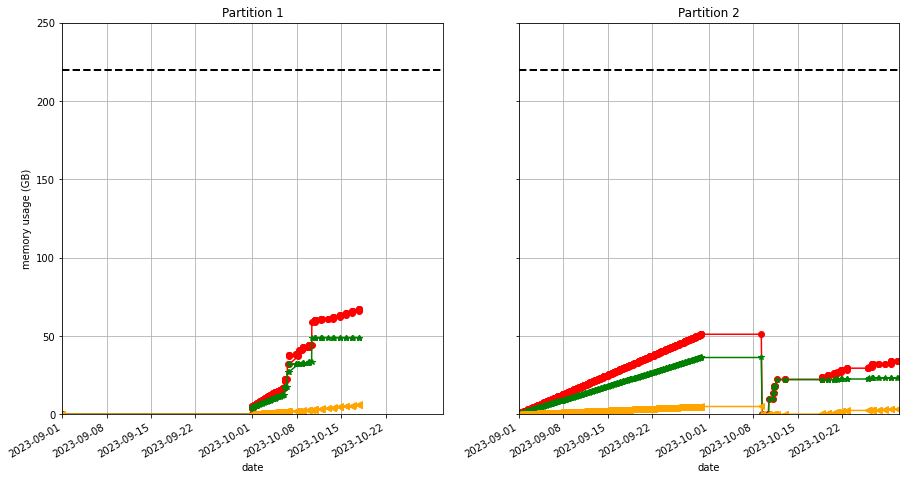

In [18]:
xlim = (DT(2023,9,1,0,0,0),DT(2023,10,31,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)


# <span style="color:red">*RSW 11*</span>

## <span style="color:blue">R_SMALL_MRES_MCAD_AR-Long-Term</span> <br>

In [19]:
t0 = DT.fromisoformat('2023-10-12T00:00:00')
t1 = DT.fromisoformat('2023-10-17T11:30:00')
id = 2
crop = 1792

AR1 = PHI_MODE('HRT')
kw = AR1.observation(t0,t1,cadence=60,shape=(2048,crop,4,6)); PHI.saving(id,**kw)

t0 = DT.fromisoformat('2023-10-17T21:30:00')
t1 = DT.fromisoformat('2023-10-20T00:00:00')

kw = AR1.observation(t0,t1,cadence=60,shape=(2048,crop,4,6)); PHI.saving(id,**kw)

# 1 day test for LCT: 1h cadence, two datasets one after the other --> 24 more datasets
kw = AR1.observation(DT(2023,10,18,0,0,2),24,cadence=60,shape=(2048,crop,4,6)); PHI.saving(id,**kw)

for i in range(20):
    kw = AR1.cropping(DT(2023,11,3,9,0,0)+TD(days=i),crop=[crop,crop],ndata=10,level='raw')#; PHI.saving(id,**kw)
    kw = AR1.packing(kw['end']+TD(minutes=5),ndata=10,level='raw.crop',); PHI.saving(id,**kw)
    kw = AR1.compressing(kw['end']+TD(minutes=5),ndata=10,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)
kw = AR1.cropping(DT(2023,11,3,9,0,0)+TD(days=i),crop=[crop,crop],ndata=5,level='raw')#; PHI.saving(id,**kw)
kw = AR1.packing(kw['end']+TD(minutes=5),ndata=5,level='raw.crop',); PHI.saving(id,**kw)
kw = AR1.compressing(kw['end']+TD(minutes=5),ndata=5,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)

printp(AR1, label='AR Long Term 1')

AR Long Term 1
number of datasets: 205
cadence: 60 mins
duration: 1 day, 0:00:00
amount of raw-data at 32 bits: 71945.2 MiB, 351.0 MiB per dataset
crop size: 1792
amount of crop-data at 32 bits: 62561.0 MiB, 305.2 MiB per dataset
cropping time: 3:59:10
amount of pack-data at 16 bits: 32844.5 MiB, 160.2 MiB per dataset
packing time: 5:07:30
amount of compressed data + metadata at 6 bits: 11302.4 MiB, 55.1 MiB per dataset
compressing (+ flushing) time: 1 day, 2:20:11.273280
amount of metadata:  272.045 MiB
amount of memory usage: 167350.8 MiB



## <span style="color:blue">R_SMALL_HRES_MCAD_Polar-Observations</span>

In [40]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-17T11:30:00')
t1 = DT.fromisoformat('2023-10-17T20:30:00')
polar1 = PHI_MODE('HRT')
crop = 1536

# cadence 20m to 30m to get some telemetry for high cadence
kw = polar1.observation(t0,t0+TD(minutes=20),cadence=100/60,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = polar1.observation(t0+TD(minutes=20),t0+TD(hours=6),cadence=30,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = polar1.cropping(kw['end']+TD(minutes=15),crop=crop,ndata=-1,level = 'raw');# PHI.saving(id,**kw)
kw = polar1.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = polar1.compressing(DT(2023,10,23,18,0,0),ndata=-1,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)
# kw = polar1.compressing(DT(2023,10,23,18,0,0),ndata=15,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)
# kw = polar1.compressing(DT(2023,10,24,18,0,0),ndata=15,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)
# kw = polar1.compressing(DT(2023,10,25,18,0,0),ndata=16,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)

########################################################
printp(polar1, label='Polar Observations')


Polar Observations
number of datasets: 23
cadence: 30 mins
duration: 5:40:00
amount of raw-data at 32 bits: 6843.6 MiB, 297.5 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 5264.3 MiB, 228.9 MiB per dataset
cropping time: 0:26:50
amount of pack-data at 16 bits: 2807.6 MiB, 122.1 MiB per dataset
packing time: 0:34:30
amount of compressed data + metadata at 6 bits: 931.7 MiB, 40.5 MiB per dataset
compressing (+ flushing) time: 2:10:15.644352
amount of metadata:  456.207 MiB
amount of memory usage: 14915.5 MiB



## <span style="color:magenta">***RESET NAND 1***</span>

In [21]:
print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e-3,2), 'GB')
PHI.format_partition(1,DT(2023,10,20,1,0,0))

amount of compressed data + metadata in partition 1: 6.31 GB


## <span style="color:blue">R_SMALL_HRES_HCAD_Atmospheric-Dynamics-Structure</span> <br>

In [24]:
t0 = DT.fromisoformat('2023-10-20T07:00:00')
t1 = DT.fromisoformat('2023-10-20T13:00:00')
id = 1
crop = 1408 # 1536 # 1280 # 

ADS = PHI_MODE('HRT')
kw = ADS.observation(t0,t1,cadence=1,shape=(2048,crop,4,6)); PHI.saving(id,**kw)

for i in range(30):
    kw = ADS.cropping(DT(2023,11,23,9,0,0)+TD(days=i),[crop,crop],ndata=12,level='raw');# PHI.saving(id,**kw)
    kw = ADS.packing(kw['end'],ndata=12,level='raw.crop',); PHI.saving(id,**kw)
    kw = ADS.compressing(kw['end']+TD(minutes=15),ndata=12,nbits=6,level='raw.crop.pack'); PHI.saving(id,**kw)

printp(ADS,label='ATMOSPHERIC-DYNIMICS-STRUCTURE')

ATMOSPHERIC-DYNIMICS-STRUCTURE
number of datasets: 360
cadence: 1 mins
duration: 6:00:00
amount of raw-data at 32 bits: 98877.0 MiB, 274.7 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 68664.6 MiB, 190.7 MiB per dataset
cropping time: 7:00:00
amount of pack-data at 16 bits: 35705.6 MiB, 99.2 MiB per dataset
packing time: 9:00:00
amount of compressed data + metadata at 6 bits: 12254.3 MiB, 34.0 MiB per dataset
compressing (+ flushing) time: 1 day, 4:33:16.853760
amount of metadata:  3072.108 MiB
amount of memory usage: 203247.1 MiB



## <span style="color:blue">LIMB (STIX+METIS)</span>
<span style="color:red">crop to 1536 px to save telemetry</span>

In [23]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-20T10:00:00')
t1 = DT.fromisoformat('2023-10-21T00:00:00')
LI = PHI_MODE('HRT')
crop = 1536

# cadence 60s to 100s to get some telemetry for high cadence
kw = LI.observation(t0,1,cadence=2,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = LI.cropping(kw['end']+TD(minutes=10),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = LI.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = LI.compressing(kw['end']+TD(minutes=10),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

########################################################
printp(LI, label='Limb (STIX + METIS)')


Limb (STIX + METIS)
number of datasets: 1
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 297.5 MiB, 297.5 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 228.9 MiB, 228.9 MiB per dataset
cropping time: 0:01:10
amount of pack-data at 16 bits: 122.1 MiB, 122.1 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 40.5 MiB, 40.5 MiB per dataset
compressing (+ flushing) time: 0:05:39.810624
amount of metadata:  24.009 MiB
amount of memory usage: 648.5 MiB



## <span style="color:blue">L_BOTH_HRES_LCAD_CH-Boundary-Expansion</span>

In [24]:
128*11

1408

In [42]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-21T00:00:00')
t1 = DT.fromisoformat('2023-10-22T00:00:00')
CH1 = PHI_MODE('FDT')

synoptic_raw(PHI,CH1,t0,t1,720,(2048,1408,4,6),6,id)

# 1h@1m cadence test
# crop = 1408
# kw = CH1.observation(t0+TD(hours=1),60,cadence=1,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
# for i in range(10):
#     kw = CH1.cropping(DT(2023,12,1,17,0,0)+TD(days=i),crop=crop,ndata=6,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
#     kw = CH1.packing(kw['end'],ndata=6,level = 'raw.crop'); PHI.saving(id,**kw)
#     kw = CH1.compressing(kw['end']+TD(minutes=60),ndata=6,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

########################################################
printp(CH1, label='CH boundary expansion + 1h@1m')


CH boundary expansion + 1h@1m
number of datasets: 2
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 549.3 MiB, 274.7 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 381.5 MiB, 190.7 MiB per dataset
cropping time: 0:02:20
amount of pack-data at 16 bits: 198.4 MiB, 99.2 MiB per dataset
packing time: 0:03:00
amount of compressed data + metadata at 6 bits: 68.1 MiB, 34.0 MiB per dataset
compressing (+ flushing) time: 0:09:31.093632
amount of metadata:  24.009 MiB
amount of memory usage: 1129.2 MiB



## <span style="color:green">HRT Flat 3</span>

In [26]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-10-22T00:00:00')
HRTflat3 = HRT_flat(PHI,t0,id,DT(2023,10,23,7,0,0),DT(2023,10,24,22,0,0),verbose=False)
########################################################
printp(HRTflat3, label="HRT FLAT 3 (22/10/2023)")

HRT FLAT 3 (22/10/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



# <span style="color:magenta">*RSW 12*</span>

## <span style="color:blue">L_FULL_HRES_HCAD_Eruption-Watch</span>

In [27]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-23T00:00:00')
t1 = DT.fromisoformat('2023-10-24T00:00:00')
CH1 = PHI_MODE('FDT')

synoptic_raw(PHI,CH1,t0,t1,360,(2048,1408,4,6),6,id)

########################################################
printp(CH1, label='CH boundary expansion')


CH boundary expansion
number of datasets: 4
cadence: 2 mins
duration: 0:02:00
amount of raw-data at 32 bits: 1098.6 MiB, 274.7 MiB per dataset
crop size: 1408
amount of crop-data at 32 bits: 762.9 MiB, 190.7 MiB per dataset
cropping time: 0:04:40
amount of pack-data at 16 bits: 396.7 MiB, 99.2 MiB per dataset
packing time: 0:06:00
amount of compressed data + metadata at 6 bits: 136.2 MiB, 34.0 MiB per dataset
compressing (+ flushing) time: 0:19:02.187264
amount of metadata:  24.009 MiB
amount of memory usage: 2258.3 MiB



## <span style="color:blue">Fast Wind 2</span>


In [34]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-10-24T10:00:00')
t1 = DT.fromisoformat('2023-10-26T22:00:00')
FW2 = PHI_MODE('HRT')

kw = FW2.observation(t0,2,cadence=30,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = FW2.binning(kw['end']+TD(minutes=10),2,ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW2.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw.bin'); PHI.saving(id,**kw)
kw = FW2.compressing(kw['end']+TD(minutes=10),ndata=2,nbits=6,level = 'raw.bin.pack'); PHI.saving(id,**kw)

kw = FW2.observation(t0+TD(days=1),2,cadence=30,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = FW2.binning(kw['end']+TD(minutes=10),2,ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW2.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw.bin'); PHI.saving(id,**kw)
kw = FW2.compressing(kw['end']+TD(minutes=10),ndata=2,nbits=6,level = 'raw.bin.pack'); PHI.saving(id,**kw)

kw = FW2.observation(t0+TD(days=2),2,cadence=30,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = FW2.binning(kw['end']+TD(minutes=10),2,ndata=-1,level = 'raw'); PHI.saving(id,**kw)
kw = FW2.packing(kw['end']+TD(minutes=10),ndata=-1,level = 'raw.bin'); PHI.saving(id,**kw)
kw = FW2.compressing(kw['end']+TD(minutes=10),ndata=2,nbits=6,level = 'raw.bin.pack'); PHI.saving(id,**kw)

########################################################
printp(FW2, label='Fast Wind 2')


Fast Wind 2
number of datasets: 6
cadence: 30 mins
duration: 1:00:00
amount of raw-data at 32 bits: 2380.4 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 366.2 MiB, 61.0 MiB per dataset
packing time: 0:04:30
amount of compressed data + metadata at 6 bits: 108.1 MiB, 18.0 MiB per dataset
compressing (+ flushing) time: 0:15:06.401664
amount of metadata:  32.018 MiB
amount of memory usage: 3387.5 MiB



## <span style="color:blue">R_SMALL_HRES_MCAD_Full-Disk-Mosaic</span>

In [29]:
########################################################
id = 2
t0 = DT.fromisoformat('2023-10-27T10:00:00')
t1 = t0 + TD(minutes=175) #25 datasets
crazy = PHI_MODE('HRT')

kw = crazy.observation(t0,25,cadence=7,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = crazy.packing(DT(2023,10,28,5,0,0),ndata=-1,level = 'raw'); PHI.saving(id,**kw)
# kw = crazy.compressing(DT(2023,3,22,22,0,0),ndata=-1,nbits=6,level='raw.pack'); phi.saving(id,**kw); PHI.saving(id,**kw)
kw = crazy.compressing(DT(2023,10,28,18,35,0),ndata=5,nbits=6,level='raw.pack'); PHI.saving(id,**kw)
kw = crazy.compressing(DT(2023,10,29,18,35,0),ndata=5,nbits=6,level='raw.pack'); PHI.saving(id,**kw)
kw = crazy.compressing(DT(2023,10,30,18,35,0),ndata=5,nbits=6,level='raw.pack'); PHI.saving(id,**kw)
kw = crazy.compressing(DT(2023,10,31,18,35,0),ndata=5,nbits=6,level='raw.pack'); PHI.saving(id,**kw)
kw = crazy.compressing(DT(2023,11,1,18,35,0),ndata=5,nbits=6,level='raw.pack'); PHI.saving(id,**kw)

########################################################
printp(crazy, label='Crazy Mosaic')


Crazy Mosaic
number of datasets: 25
cadence: 7 mins
duration: 2:55:00
amount of raw-data at 32 bits: 9918.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 5149.8 MiB, 206.0 MiB per dataset
packing time: 0:37:30
amount of compressed data + metadata at 6 bits: 1800.2 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 4:11:41.294400
amount of metadata:  400.045 MiB
amount of memory usage: 15068.1 MiB



## <span style="color:blue">R_BOTH_HRES_MCAD_Bright-Points</span>

In [37]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-10-27T22:00:00')
t1 = DT.fromisoformat('2023-10-28T06:00:00')
BP = PHI_MODE('HRT')
crop = 1024

kw = BP.observation(t0,t1,cadence=30,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = BP.cropping(DT(2023,10,29,20,5),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
kw = BP.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = BP.compressing(DT(2023,11,2,22,0),ndata=-1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

########################################################
printp(BP, label='Bright Points')


Bright Points
number of datasets: 16
cadence: 30 mins
duration: 8:00:00
amount of raw-data at 32 bits: 3295.9 MiB, 206.0 MiB per dataset
crop size: 1024
amount of crop-data at 32 bits: 1709.0 MiB, 106.8 MiB per dataset
cropping time: 0:09:20
amount of pack-data at 16 bits: 976.6 MiB, 61.0 MiB per dataset
packing time: 0:12:00
amount of compressed data + metadata at 6 bits: 288.1 MiB, 18.0 MiB per dataset
compressing (+ flushing) time: 0:40:17.071104
amount of metadata:  384.144 MiB
amount of memory usage: 5981.4 MiB



## <span style="color:blue">R_SMALL_HRES_MCAD_AR-Heating</span>

In [39]:
########################################################
id = 1
t0 = DT.fromisoformat('2023-10-28T08:43:00')
ARh = PHI_MODE('HRT')
crop = 1536

kw = ARh.observation(t0,1,cadence=60,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
kw = ARh.cropping(kw['end']+TD(minutes=10),crop,ndata=-1,level = 'raw')
kw = ARh.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = ARh.compressing(kw['end']+TD(minutes=10),ndata=1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

kw = ARh.observation(t0+TD(days=1),1,cadence=60,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = ARh.cropping(kw['end']+TD(minutes=10),crop,ndata=-1,level = 'raw')
kw = ARh.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = ARh.compressing(kw['end']+TD(minutes=10),ndata=1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

kw = ARh.observation(t0+TD(days=2),1,cadence=60,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = ARh.cropping(kw['end']+TD(minutes=10),crop,ndata=-1,level = 'raw')
kw = ARh.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = ARh.compressing(kw['end']+TD(minutes=10),ndata=1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

kw = ARh.observation(t0+TD(days=3),1,cadence=60,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = ARh.cropping(kw['end']+TD(minutes=10),crop,ndata=-1,level = 'raw')
kw = ARh.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = ARh.compressing(kw['end']+TD(minutes=10),ndata=1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

kw = ARh.observation(t0+TD(days=4),1,cadence=60,shape=(2048,2048,4,6)); PHI.saving(id,**kw)
kw = ARh.cropping(kw['end']+TD(minutes=10),crop,ndata=-1,level = 'raw')
kw = ARh.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
kw = ARh.compressing(kw['end']+TD(minutes=10),ndata=1,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

########################################################
printp(ARh, label='AR Heating 2')


AR Heating 2
number of datasets: 5
cadence: 60 mins
duration: 1:00:00
amount of raw-data at 32 bits: 1884.5 MiB, 376.9 MiB per dataset
crop size: 1536
amount of crop-data at 32 bits: 1144.4 MiB, 228.9 MiB per dataset
cropping time: 0:05:50
amount of pack-data at 16 bits: 610.4 MiB, 122.1 MiB per dataset
packing time: 0:07:30
amount of compressed data + metadata at 6 bits: 202.5 MiB, 40.5 MiB per dataset
compressing (+ flushing) time: 0:28:19.053120
amount of metadata:  24.009 MiB
amount of memory usage: 3639.2 MiB



## <span style="color:blue">R_SMALL_HRES_MCAD_Polar-Observations</span>

In [41]:
# ########################################################
# id = 1
# t0 = DT.fromisoformat('2023-10-31T10:00:00')
# t1 = DT.fromisoformat('2023-10-31T13:00:00')
# BP = PHI_MODE('HRT')
# crop = 1536

# kw = BP.observation(t0,t1,cadence=10,shape=(2048,crop,4,6)); PHI.saving(id,**kw)
# kw = BP.cropping(DT(2023,10,31,16,0,0),crop=crop,ndata=-1,level = 'raw');# phi.saving(id,**kw); PHI.saving(id,**kw)
# kw = BP.packing(kw['end'],ndata=-1,level = 'raw.crop'); PHI.saving(id,**kw)
# kw = BP.compressing(DT(2023,10,31,22,0),ndata=9,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)
# kw = BP.compressing(DT(2023,11,1,22,0),ndata=9,nbits=6,level = 'raw.crop.pack'); PHI.saving(id,**kw)

# ########################################################
# printp(BP, label='Polar 2')


# <span style="color:white">*out of RSWs*</span>

## <span style="color:green">FDT Flat 4</span>

In [33]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-11-02T01:00:00')
FDTflat4 = FDT_flat(PHI,t0,id,DT(2023,11,4,6,0,0),'auto',verbose=False)
########################################################
printp(FDTflat4, label="FDT FLAT 4 (02/11/2023)")

FDT FLAT 4 (02/11/2023)
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4173.3 MiB



## <span style="color:green">HRT Flat 4</span>

In [34]:
########################################################
id = 2

t0 = DT.fromisoformat('2023-11-02T03:00:00')
HRTflat4 = HRT_flat(PHI,t0,id,DT(2023,11,5,6,0,0),'auto',verbose=False)
########################################################
printp(HRTflat4, label="HRT FLAT 5 (02/11/2023)")

HRT FLAT 5 (02/11/2023)
number of datasets: 11
cadence: 15.0 mins
duration: 0:15:00
amount of raw-data at 32 bits: 4364.0 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 206.0 MiB per dataset
packing time: 0:01:30
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
compressing (+ flushing) time: 0:10:04.051776
amount of metadata:  16.009 MiB
amount of memory usage: 4570.0 MiB



## <span style="color:green">Synoptic</span>

CROP+PACK

<span style="color:red">cadence to 4h to save telemetry</span>

In [35]:
# ########################################################
# id = 2
# t0 = DT.fromisoformat('2023-04-26T00:00:00')
# t1 = DT.fromisoformat('2023-05-04T00:00:00')
# DF = PHI_MODE('FDT')

# synoptic_raw(PHI,DF,t0,t1,240,(2048,1280,4,6),6,id,crop_pack=True)

# ########################################################
# printp(DF, label='Synoptic')


## <span style="color:green">Synoptic</span>

3h cadence

In [36]:
# ########################################################
# id = 2
# t0 = DT.fromisoformat('2023-05-04T04:00:00')
# t1 = DT.fromisoformat('2023-05-20T00:00:00')
# DF = PHI_MODE('FDT')
# crop = 1536

# synoptic_raw(PHI,DF,t0,t1,240,(2048,crop,4,6),6,id)

# ########################################################
# printp(DF, label='Synoptic')


In [37]:
# ########################################################
# id = 2
# t0 = DT.fromisoformat('2023-05-20T04:00:00')
# t1 = DT.fromisoformat('2023-08-02T00:00:00')
# DF = PHI_MODE('FDT')

# synoptic_raw(PHI,DF,t0,t1,240,(2048,1024,4,6),6,id)

# ########################################################
# printp(DF, label='Synoptic')


# <span style="color:yellow">PLOTS</span>

We should try to format partition two at some point, in this way we could add more FDT synoptic during and after RSWs.

Implementing CROP+Pack would save ~70 GB of memory in NAND1

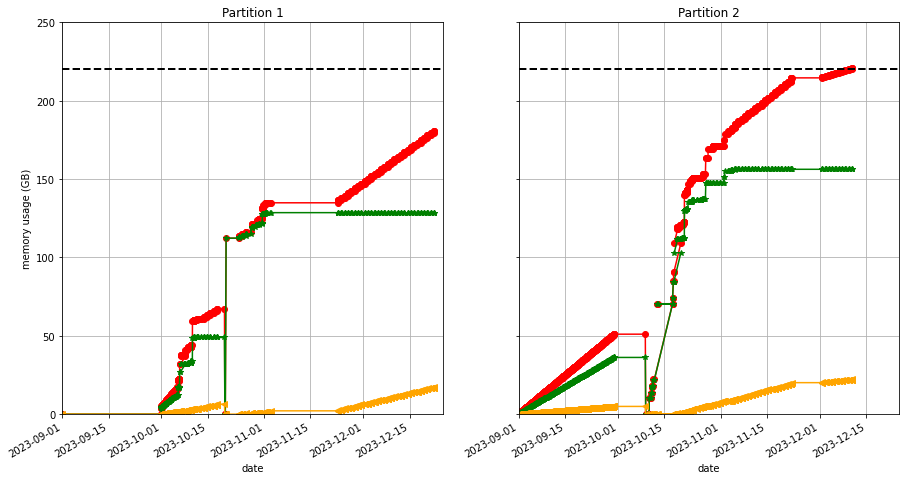

In [38]:
xlim = (DT(2023,9,1,0,0,0),DT(2023,12,25,0,0,0))
plot_tot(PHI, xlim=xlim, ylim=(0,250), time_ord=True)
# plt.savefig('/home/calchetti/MPStemp/pics/TM/total_v5.1.png')

# fname = '/home/calchetti/MPStemp/PHI_TMtool/TM_NMP1_v2.csv'
# PHI.save(fname)

/tmp/ipykernel_1371048/4027334492.py:217: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(times,newc1+newc2,color='black',linestyle='-',marker='.',label='total: '+str(round(total,1))+' GB')


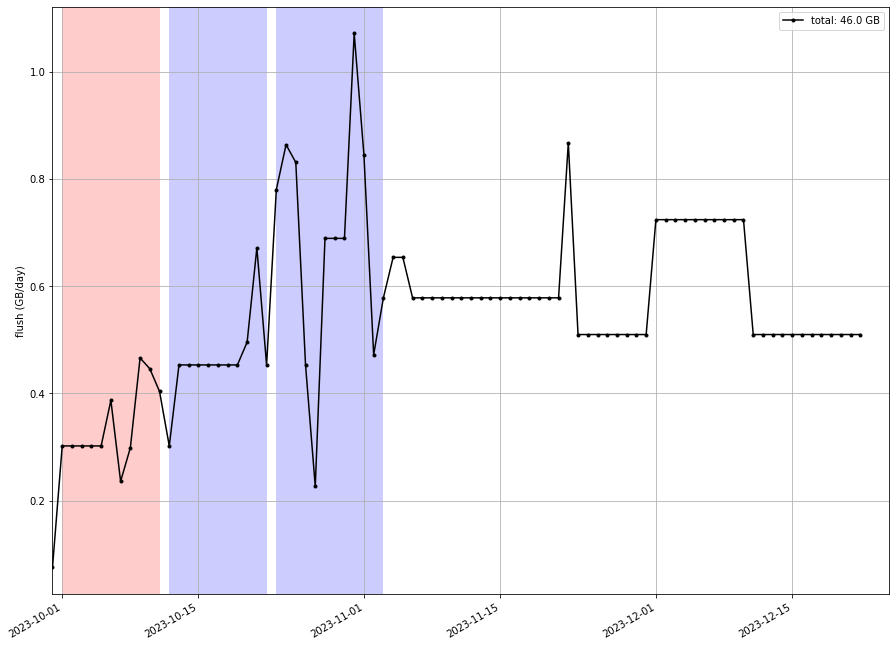

In [39]:
xlim = (DT(2023,9,30,0,0,0),DT(2023,12,25,0,0,0))
tt, tm1, tm2 = plot_flush_per_day(PHI,xlim,values=True)
ylim = plt.gca().get_ylim()
plt.fill_betweenx(ylim,DT(2023,10,1),DT(2023,10,11),facecolor='red',alpha=.2);
plt.fill_betweenx(ylim,DT(2023,10,12),DT(2023,10,22),facecolor='blue',alpha=.2);
plt.fill_betweenx(ylim,DT(2023,10,23),DT(2023,11,3),facecolor='blue',alpha=.2);
plt.ylim(ylim);
# 1 GB = 2.2h of flushing

In [39]:
rsw10 = [DT(2023,9,30,0,0,0),DT(2023,10,12,0,0,0)]
rsw11 = [DT(2023,10,12,0,0,0),DT(2023,10,23,0,0,0)]
rsw12 = [DT(2023,10,23,0,0,0),DT(2023,11,3,0,0,0)]

rsw10_1 = tm1[np.where(np.logical_and(tt>=rsw10[0].date(),tt<rsw10[1].date()))] * 1e9 / 2**20
rsw10_2 = tm2[np.where(np.logical_and(tt>=rsw10[0].date(),tt<rsw10[1].date()))]* 1e9 / 2**20

rsw11_1 = tm1[np.where(np.logical_and(tt>=rsw11[0].date(),tt<rsw11[1].date()))]* 1e9 / 2**20
rsw11_2 = tm2[np.where(np.logical_and(tt>=rsw11[0].date(),tt<rsw11[1].date()))]* 1e9 / 2**20

rsw12_1 = tm1[np.where(np.logical_and(tt>=rsw12[0].date(),tt<rsw12[1].date()))]* 1e9 / 2**20
rsw12_2 = tm2[np.where(np.logical_and(tt>=rsw12[0].date(),tt<rsw12[1].date()))]* 1e9 / 2**20

out_1 = tm1[np.where(tt>=rsw12[1].date())]* 1e9 / 2**20
out_2 = tm2[np.where(tt>=rsw12[1].date())]* 1e9 / 2**20

print('(MiB)\tNAND-1\tNAND-2\ttotal')
print(f'RSW-10\t{int(round(rsw10_1.sum(),0))}\t{int(round(rsw10_2.sum(),0))}\t{int(round(rsw10_1.sum()+rsw10_2.sum(),0))}')
print(f'RSW-11\t{int(round(rsw11_1.sum(),0))}\t{int(round(rsw11_2.sum(),0))}\t{int(round(rsw11_1.sum()+rsw11_2.sum(),0))}')
print(f'RSW-12\t{int(round(rsw12_1.sum(),0))}\t{int(round(rsw12_2.sum(),0))}\t{int(round(rsw12_1.sum()+rsw12_2.sum(),0))}')
print(f'total\t{int(round(rsw10_1.sum()+rsw11_1.sum()+rsw12_1.sum(),0))}\t{int(round(rsw10_2.sum()+rsw11_2.sum()+rsw12_2.sum(),0))}'+
      f'\t{int(round(rsw10_1.sum()+rsw10_2.sum()+rsw11_1.sum()+rsw11_2.sum()+rsw12_1.sum()+rsw12_2.sum(),0))}')
print('')
print(f'out\t{int(round(out_1.sum(),0))}\t{int(round(out_2.sum(),0))}\t{int(round(out_1.sum()+out_2.sum(),0))}')


(MiB)	NAND-1	NAND-2	total
RSW-10	3646	0	3646
RSW-11	2376	2633	5009
RSW-12	2016	5392	7408
total	8038	8025	16063

out	14583	10123	24706


In [40]:
print('DATE\tFLUSH NAND-1 (MiB)\tFLUSH NAND-2 (MiB)')
for tti, tm1i, tm2i in zip(tt,tm1,tm2):
    print(str(tti)+'\t'+'{:.0f}'.format(tm1i*1e9/2**20)+'\t'+'{:.0f}'.format(tm2i*1e9/2**20))

DATE	FLUSH NAND-1 (MiB)	FLUSH NAND-2 (MiB)
2023-09-01	162	0
2023-09-02	162	0
2023-09-03	162	0
2023-09-04	162	0
2023-09-05	162	0
2023-09-06	162	0
2023-09-07	162	0
2023-09-08	162	0
2023-09-09	162	0
2023-09-10	162	0
2023-09-11	162	0
2023-09-12	162	0
2023-09-13	162	0
2023-09-14	162	0
2023-09-15	162	0
2023-09-16	162	0
2023-09-17	162	0
2023-09-18	162	0
2023-09-19	162	0
2023-09-20	162	0
2023-09-21	162	0
2023-09-22	162	0
2023-09-23	162	0
2023-09-24	162	0
2023-09-25	162	0
2023-09-26	162	0
2023-09-27	162	0
2023-09-28	162	0
2023-09-29	162	0
2023-09-30	0	72
2023-10-01	288	0
2023-10-02	288	0
2023-10-03	288	0
2023-10-04	288	0
2023-10-05	288	0
2023-10-06	241	72
2023-10-07	169	0
2023-10-08	529	0
2023-10-09	529	0
2023-10-10	169	473
2023-10-11	385	648
2023-10-12	0	432
2023-10-13	0	432
2023-10-14	216	432
2023-10-15	0	432
2023-10-16	0	432
2023-10-17	0	2295
2023-10-18	0	432
2023-10-19	0	432
2023-10-20	0	41
2023-10-21	0	288
2023-10-22	0	72
2023-10-23	0	288
2023-10-24	144	0
2023-10-25	144	0
2023-10-26	144	0


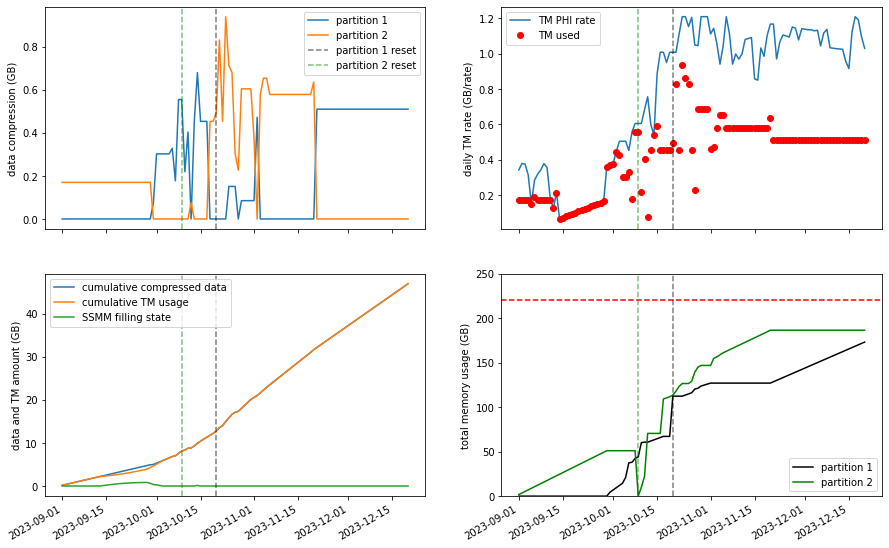

In [55]:
from scipy.interpolate import interp1d
tot1 = np.asarray(PHI.part1.history['occu'])
tot2 = np.asarray(PHI.part2.history['occu'])
c1 = np.asarray(PHI.part1.history['compr'])
c2 = np.asarray(PHI.part2.history['compr'])
d1 = np.asarray(PHI.part1.history['start'])
d2 = np.asarray(PHI.part2.history['start'])

starttime = min(min(d1),min(d2))
endtime = max(max(d1),max(d2))
t0 = starttime
times = []
while starttime.date() <= endtime.date():
    times.append(starttime.date())
    starttime += TD(days=1)
starttime = t0; del t0
times_float = [(t - d1[0]).total_seconds() for t in d1]
times = np.asarray(times)

s = np.argsort(d1)

newtot1 = np.zeros(np.size(times))
for i,j in zip(d1,tot1):
    if True:
        ind = np.where(times == i.date())[0]
        newtot1[ind] += j/1e3
newtot1 = np.asarray(newtot1)

newtot2 = np.zeros(np.size(times))
for i,j in zip(d2,tot2):
    if True:
        ind = np.where(times == i.date())[0]
        newtot2[ind] += j/1e3
newtot2 = np.asarray(newtot2)

newc1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc1[ind] += j/1e3
newc1 = np.asarray(newc1)


newc2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc2[ind] += j/1e3
newc2 = np.asarray(newc2)

form1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j<0:
        ind = np.where(times == i.date())[0]
        form1[ind] += j/1e3
form1 = np.asarray(form1)


form2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j<0:
        ind = np.where(times == i.date())[0]
        form2[ind] += j/1e3
form2 = np.asarray(form2)

trig1 = np.where(form1 < 0)[0]
trig2 = np.where(form2 < 0)[0]

x = TM3['date'][np.logical_and(TM3['date'] <= endtime+TD(days=1),TM3['date'] >= starttime-TD(days=1))]
y = TM3['tm_rate'][np.logical_and(TM3['date'] <= endtime+TD(days=1),TM3['date'] >= starttime-TD(days=1))]
z = TM3['duration'][np.logical_and(TM3['date'] <= endtime+TD(days=1),TM3['date'] >= starttime-TD(days=1))]

xx = [(i - starttime).total_seconds() for i in x]
f = interp1d(xx, y*z,fill_value='extrapolate')
xnew = [(i - starttime.date()).total_seconds() for i in times]
ynew = f(xnew)/8e9
ynew[times<datetime.date(2023,4,1)] *= .2
ynew[times>=datetime.date(2023,4,1)] *= .3

tm_used = np.zeros(times.size)
down = 0#np.zeros(times.size)
for i in range(times.size):
    if newc1[i] > 0 or newc2[i] > 0:
        tm_used[i] = min(ynew[i],np.sum(newc1[:i+1] + newc2[:i+1]) - tm_used[:i].sum())
        down = max(0,np.sum(newc1[:i+1] + newc2[:i+1] - tm_used[:i+1]))
    else:
        if down > 0:
            tm_used[i] = min(ynew[i],np.sum(newc1[:i+1] + newc2[:i+1]) - tm_used[:i].sum())
            down = max(0,np.sum(newc1[:i+1] + newc2[:i+1] - tm_used[:i+1]))

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.ylabel('data compression (GB)')
plt.plot(times,newc1,label='partition 1')
plt.plot(times,newc2,label='partition 2')
for i,t in enumerate(trig1):
    if i == 0:
        plt.axvline(times[t],linestyle='--',color='k',alpha=.5,label='partition 1 reset')
    else:
        plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for i,t in enumerate(trig2):
    if i == 0:
        plt.axvline(times[t],linestyle='--',color='g',alpha=.5,label='partition 2 reset')
    else:
        plt.axvline(times[t],linestyle='--',color='g',alpha=.5)
plt.legend()

plt.subplot(222)
plt.ylabel('daily TM rate (GB/rate)')
plt.plot(times,ynew,label='TM PHI rate')
plt.plot(times,tm_used,'ro',label='TM used')
plt.legend()
for t in trig1:
    plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for t in trig2:
    plt.axvline(times[t],linestyle='--',color='g',alpha=.5)
# print('total1408 TM used:',round(tm_used.sum(),2),'GB')
# print('total compressed data:',round((newc1+newc2).sum(),2),'GB')
# plt.xlim(datetime.date(2023,1,10),datetime.date(2023,2,5))
plt.subplot(223)
# cond = np.logical_and(times>=FL['date'][0].date(), times<=FL['date'][-1].date())
cond = np.ones(np.size(times),dtype=bool)
plt.ylabel('data and TM amount (GB)')
plt.plot(times[cond],np.cumsum(newc1[cond]+newc2[cond]),label='cumulative compressed data')
plt.plot(times[cond],np.cumsum(tm_used[cond]),label='cumulative TM usage')
plt.plot(times[cond],np.cumsum(newc1[cond]+newc2[cond])-np.cumsum(tm_used[cond]),label='SSMM filling state')
# plt.plot(FL['date'],-np.cumsum(FL['flush']*2**20/1e9),'m',label='SOOPK FLUSH')
# cond = np.logical_and(FL['date']>DT(2023,1,19,0,0), FL['date']<DT(2023,5,1,0,0))
# plt.plot(FL['date'][cond],-np.cumsum(FL['flush'][cond]*2**20/1e9),'m',label='SOOPK FLUSH')
plt.legend()
for t in trig1:
    plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for t in trig2:
    plt.axvline(times[t],linestyle='--',color='g',alpha=.5)

plt.subplot(224)
plt.ylabel('total memory usage (GB)')
plt.plot(times,np.cumsum(newtot1),'k',label='partition 1')
plt.plot(times,np.cumsum(newtot2),'g',label='partition 2')
plt.legend()
plt.ylim(0,250)
plt.axhline(220,linestyle='--',color='r')
for t in trig1:
    plt.axvline(times[t],linestyle='--',color='k',alpha=.5)
for t in trig2:
    plt.axvline(times[t],linestyle='--',color='g',alpha=.5)

plt.gcf().autofmt_xdate()
# plt.savefig('/home/calchetti/MPStemp/pics/TM/tm_v5.1.png')

In [132]:
print('Total amount of TM used:',round(tm_used.sum(),2),'GB')
print('Total amount of compressed data:',round((newc1+newc2).sum(),2),'GB')

Total amount of TM used: 50.56 GB
Total amount of compressed data: 50.56 GB


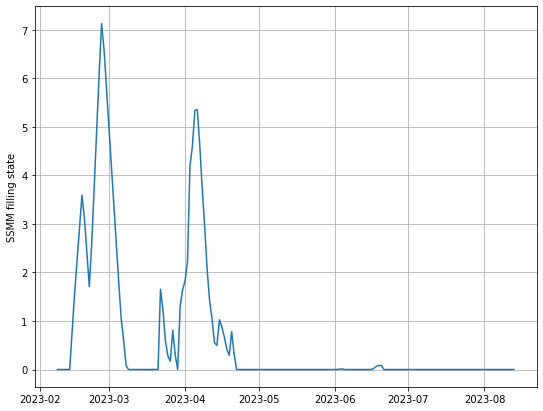

In [133]:
plt.figure(figsize=(9,7))
plt.plot(times,np.cumsum(newc1+newc2)-np.cumsum(tm_used))
plt.ylabel('SSMM filling state')
plt.grid()

In [134]:
(newc1+newc2)[times>datetime.date(2023,3,15)].sum()

34.997348592

In [135]:
PHI.part1.history.keys()
r1 = np.asarray(PHI.part1.history['raw'])[1:]
r2 = np.asarray(PHI.part2.history['raw'])[1:]
f1 = np.asarray(PHI.part1.history['compr'])[1:]
f2 = np.asarray(PHI.part2.history['compr'])[1:]
c1 = np.asarray(PHI.part1.history['crop'])[1:]
c2 = np.asarray(PHI.part2.history['crop'])[1:]
p1 = np.asarray(PHI.part1.history['proc'])[1:]
p2 = np.asarray(PHI.part2.history['proc'])[1:]
k1 = np.asarray(PHI.part1.history['pack'])[1:]
k2 = np.asarray(PHI.part2.history['pack'])[1:]
s1 = np.asarray(PHI.part1.history['start'])[1:]
s2 = np.asarray(PHI.part2.history['start'])[1:]
e1 = np.asarray(PHI.part1.history['end'])[1:]
e2 = np.asarray(PHI.part2.history['end'])[1:]

ind1 = []
for i in range(s1.size):
    if r1[i] < 0:
        ind1 += [-.6]
    elif r1[i] != 0:
        ind1 += [.3]
    elif c1[i] != 0:
        ind1 += [1.3]
    elif k1[i] != 0:
        ind1 += [2.3]
    elif f1[i] != 0:
        ind1 += [3.3]
    elif p1[i] != 0:
        ind1 += [4.3]
    else:
#         print(i)
        ind1 += [0]
ind1 = np.asarray(ind1)    
ind2 = []
for i in range(s2.size):
    if r2[i] < 0:
        ind2 += [-.3]
    elif r2[i] != 0:
        ind2 += [.6]
    elif c2[i] != 0:
        ind2 += [1.6]
    elif k2[i] != 0:
        ind2 += [2.6]
    elif f2[i] != 0:
        ind2 += [3.6]
    elif p2[i] != 0:
        ind2 += [4.6]
    else:
#         print(i)
        ind2 += [0]
ind2 = np.asarray(ind2)    

import matplotlib.dates as mdates


0

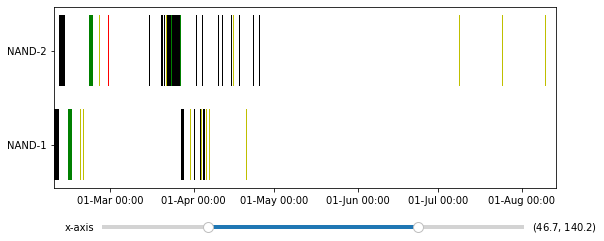

In [136]:
fig = plt.figure(figsize=(9,4))
fig.subplots_adjust(bottom=0.25)
# plt.barh(ind1,e1-s1,.3, left=s1)
# plt.barh(ind2,e2-s2,.3, left=s2)
# plt.gcf().autofmt_xdate()
# plt.xlim(min(s1[:10].min(),s2[:10].min()), max(e1[:10].max(),e2[:10].max()))
plt.barh(1,(e1-s1)[ind1==-.6],.75,left=s1[ind1==-.6],color='r')
plt.barh(1,(e1-s1)[ind1==.3],.75,left=s1[ind1==.3],color='k')
plt.barh(1,(e1-s1)[ind1==1.3],.75,left=s1[ind1==1.3],color='b')
plt.barh(1,(e1-s1)[ind1==2.3],.75,left=s1[ind1==2.3],color='g')
plt.barh(1,(e1-s1)[ind1==3.3],.75,left=s1[ind1==3.3],color='y')
plt.barh(1,(e1-s1)[ind1==4.3],.75,left=s1[ind1==4.3],color='m')

plt.barh(2,(e2-s2)[ind2==-.3],.75,left=s2[ind2==-.3],color='r')
plt.barh(2,(e2-s2)[ind2==.6],.75,left=s2[ind2==.6],color='k')
plt.barh(2,(e2-s2)[ind2==1.6],.75,left=s2[ind2==1.6],color='b')
plt.barh(2,(e2-s2)[ind2==2.6],.75,left=s2[ind2==2.6],color='g')
plt.barh(2,(e2-s2)[ind2==3.6],.75,left=s2[ind2==3.6],color='y')
plt.barh(2,(e2-s2)[ind2==4.6],.75,left=s2[ind2==4.6],color='m')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
# plt.yticks([-.6,-.3,.3,.6,1.3,1.6,2.3,2.6,3.3,3.6],['N1-Format','N2-Format','N1-Obs','N2-Obs','N1-Crop','N2-Crop','N1-Pack','N2-Pack','N1-Flush','N2-Flush','N1-Proc','N2-Proc']);
# ax.set_yticks([-.6,-.3,.3,.6,1.3,1.6,2.3,2.6,3.3,3.6],['N1-Format','N2-Format','N1-Obs','N2-Obs','N1-Crop','N2-Crop','N1-Pack','N2-Pack','N1-Flush','N2-Flush']);
ax.set_yticks([1,2],['NAND-1','NAND-2']);

from matplotlib.widgets import RangeSlider # , Button, RadioButtons

# axcolor = 'lightgoldenrodyellow'
slider_ax = fig.add_axes([0.2, 0.1, 0.65, 0.03])

min0 = min(s1.min(),s2.min())
max0 = max(e1.max(),e2.max())

slider = RangeSlider(slider_ax, "x-axis", (min0-min0).total_seconds()/60/60/24, (max0-min0).total_seconds()/60/60/24)

def update(val):    
    ax.set_xlim([min0+TD(days=val[0]),min0+TD(days=val[1])])

slider.on_changed(update)
# plt.show()


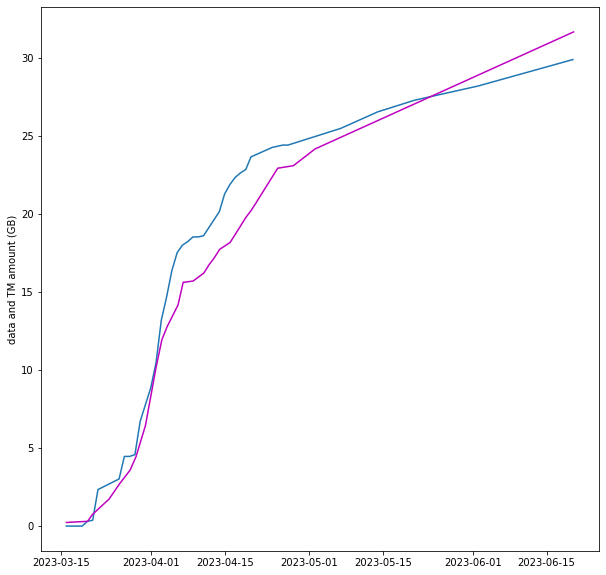

In [137]:
cond = np.logical_and(times>=FL['date'][0].date(), times<=FL['date'][-1].date())
plt.figure(figsize=(10,10))
plt.ylabel('data and TM amount (GB)')
plt.plot(times[cond],np.cumsum(newc1[cond]+newc2[cond]),label='cumulative compressed data')
# plt.plot(times[cond],np.cumsum(tm_used[cond]),label='cumulative TM usage')
# plt.plot(times[cond],np.cumsum(newc1[cond]+newc2[cond])-np.cumsum(tm_used[cond]),label='SSMM filling state')
plt.plot(FL['date'],-np.cumsum(FL['flush']*2**20/1e9),'m',label='SOOPK FLUSH')
# plt.xlim(DT(2023,3,15),DT(2023,4,10)); plt.ylim(0,20)
